In [19]:
import nltk
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tqdm.notebook import tqdm 

In [2]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    pos_lemma = {
        "J": "a",
        "N": "n",
        "V": "v"
    }

    # découpage de la phrase en liste de mots
    tokens = nltk.tokenize.word_tokenize(text)

    # suppression des mots qui ne contiennent pas uniquement des lettres
    tokens = [t for t in tokens if t.isalpha()]

    # part-of-speech tagging de chaque mot, pour déterminer leur catégorie lexicale
    # (noms, adjectifs, etc.)
    tags = nltk.pos_tag(tokens)

    # filtre des mots en fonction de leur catégorie lexicale, et lemmatization
    tokens = [
        lemmatizer.lemmatize(word, pos_lemma[pos[0]])
        for word, pos in tags
        if (pos[:2] == "NN" or pos[:2] == "JJ" or pos[:2] == "VB")
    ]
    
    return tokens

def text_to_sentences(text):
    text = text.lower()

    # découpage du texte en liste de phrases
    input_sentences = nltk.tokenize.sent_tokenize(text)
    output_sentences = []

    # tokenization et lemmatization des mots de chaque phrase, une par une
    for sentence in input_sentences:
        words = tokenize_and_lemmatize(sentence)
        output_sentences.append(words)
    
    return output_sentences

In [3]:
# chargement des articles
df = pd.read_parquet("science/climate/articles.parquet")

# chargement des abstracts (résumés des articles)
abstracts = pd.read_parquet("science/climate/abstracts.parquet")

# ajout des abstracts au dataframe des articles
df = df.merge(abstracts, how="inner", left_index=True, right_index=True)

 # retrait des articles de titre ou résumé inconnu/vide
df.dropna(subset=["title", "abstract"], inplace=True)

In [4]:
sentences = []
for article in tqdm(df.to_dict(orient="records"), desc="Processing articles"):
    text = article["title"] + ". " + article["abstract"]
    sentences += text_to_sentences(text)

Processing articles:   0%|          | 0/229433 [00:00<?, ?it/s]

In [ ]:
model = Word2Vec(
    sentences=sentences,
    vector_size=64,   # Nombre de dimensions des vecteurs dans l'espace sémantique (embeddings)
    window=3,         # Taille de la fenêtre de contexte
    min_count=5,      # Fréquence minimale des mots inclus
    workers=4,        # Nombre de coeurs de processeur utilisés pour l'entraînement
    sg=1,             # Modèle "skip-gram"
    epochs=1          # Nombre d'itérations d'entraînement
)

In [18]:
epochs = 10
for epoch in range(epochs):
    model.train(sentences, total_examples=len(sentences), epochs=1)
    target_words = ["cloud", "pricing", "bayesian"]
    for word in target_words:
        if word in model.wv:
            similar = model.wv.most_similar(word, topn=5)
            print(f"🔹 {word}: " + ", ".join(f"{w} ({s:.2f})" for w, s in similar))
        else:
            print(f"❌ {word} not in vocabulary.")

# model.save("output/word2vec.model")

🔹 cloud: cirrus (0.81), stratocumulus (0.74), anvil (0.72), stratus (0.69), clouds (0.68)
🔹 pricing: taxation (0.85), tax (0.81), tariff (0.74), trading (0.73), subsidy (0.73)
🔹 bayesian: mindsponge (0.81), hierarchal (0.80), hglm (0.79), hierarchical (0.79), igdt (0.79)
🔹 cloud: cirrus (0.80), anvil (0.72), stratocumulus (0.72), aerosol (0.68), stratus (0.68)
🔹 pricing: taxation (0.84), tax (0.80), tariff (0.79), trading (0.76), subsidy (0.72)
🔹 bayesian: hierarchal (0.80), mindsponge (0.80), igdt (0.79), hglm (0.78), graphem (0.77)
🔹 cloud: cirrus (0.78), anvil (0.74), stratocumulus (0.72), clouds (0.69), stratus (0.68)
🔹 pricing: taxation (0.85), tax (0.80), tariff (0.77), trading (0.76), market (0.73)
🔹 bayesian: mindsponge (0.81), hierarchal (0.78), igdt (0.78), hierarchical (0.77), hglm (0.77)
🔹 cloud: cirrus (0.78), stratocumulus (0.72), anvil (0.72), altocumulus (0.68), stratus (0.68)
🔹 pricing: taxation (0.83), tariff (0.79), tax (0.78), trading (0.74), market (0.72)
🔹 bayesia

In [4]:
# Chargement d'un modèle pré-entraîné
model = Word2Vec.load("output/word2vec.model")

In [5]:
df["title_words"] = df["title"].map(text_to_sentences)

In [6]:
df["title_words"] = df["title_words"].map(lambda sentences: [
    word
    for sentence in sentences
    for word in sentence
    if word in model.wv
])
df = df[df["title_words"].map(len) >= 2]

In [7]:
authors = pd.read_parquet("science/climate/authors.parquet")
articles_authors = pd.read_parquet("science/climate/articles_authors.parquet")
articles_authors = articles_authors.merge(authors, left_on="author_id", right_index=True)
article_gender = articles_authors.groupby("article_id").agg(
    male = ("gender", lambda g: np.sum(g=="m")),
    female = ("gender", lambda g: np.sum(g=="f"))
)
df = df.merge(article_gender, how="inner", left_index=True, right_index=True)

In [8]:
def words_to_embeddings(words):
    return [
        normalize(model.wv[word])
        for word in words
        if word in model.wv
   ]

def normalize(v):
    return v/np.linalg.norm(v)
    
df["embeddings"] = df["title_words"].map(words_to_embeddings)

def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

df["average_embedding"] = df["embeddings"].map(average_embedding)

In [9]:

male_docs = df[df["male"]>df["female"]]
female_docs = df[df["male"]<df["female"]]

average_male = np.mean(np.stack(male_docs["average_embedding"].values), axis=0)
average_female = np.mean(np.stack(female_docs["average_embedding"].values), axis=0)

model.wv.similar_by_vector(+(normalize(average_female)-normalize(average_male)), topn=20)

[('youth', 0.517919659614563),
 ('engage', 0.5149327516555786),
 ('woman', 0.514157235622406),
 ('justice', 0.5121480226516724),
 ('activism', 0.5067808628082275),
 ('advocacy', 0.5059552788734436),
 ('empowerment', 0.5013657808303833),
 ('ethic', 0.4904495179653168),
 ('education', 0.48617687821388245),
 ('academia', 0.47870010137557983),
 ('mental', 0.4746251702308655),
 ('profession', 0.47214415669441223),
 ('promotion', 0.47148194909095764),
 ('conversation', 0.46800199151039124),
 ('involvement', 0.4666598439216614),
 ('nursing', 0.4650914967060089),
 ('leadership', 0.46419811248779297),
 ('speak', 0.4598364233970642),
 ('engagement', 0.4594731628894806),
 ('nurture', 0.45807528495788574)]

In [10]:
document_frequency = dict()

for words in df["title_words"].tolist():
    for word in set(words):
        document_frequency[word] = document_frequency.get(word, 0)+1

In [11]:
top_words = sorted(list(document_frequency.keys()), key=lambda x: document_frequency[x], reverse=True)

/opt/anaconda3/envs/ssc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ssc/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/ssc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ssc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


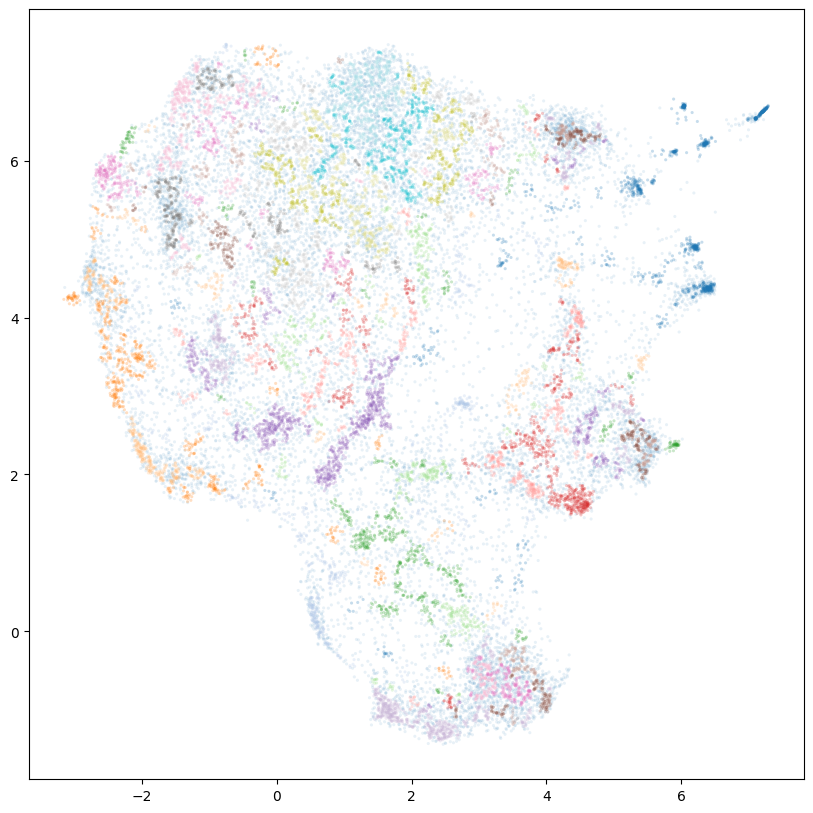

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from gensim.models import Word2Vec
import hdbscan
from scipy.spatial.distance import cosine

whitelist = top_words[:25000]

# Embeddings des mots principaux
vectors = np.array([model.wv[word] for word in whitelist])

# Réduction de dimensionalité avec UMAP
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(vectors)

# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
cluster_labels = clusterer.fit_predict(embedding)

# Création d'une figure
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    s=5,
    edgecolor='none',
    alpha=np.where(cluster_labels==-1, 0.1, 0.25),
    c=cluster_labels,
    cmap="tab20",
)

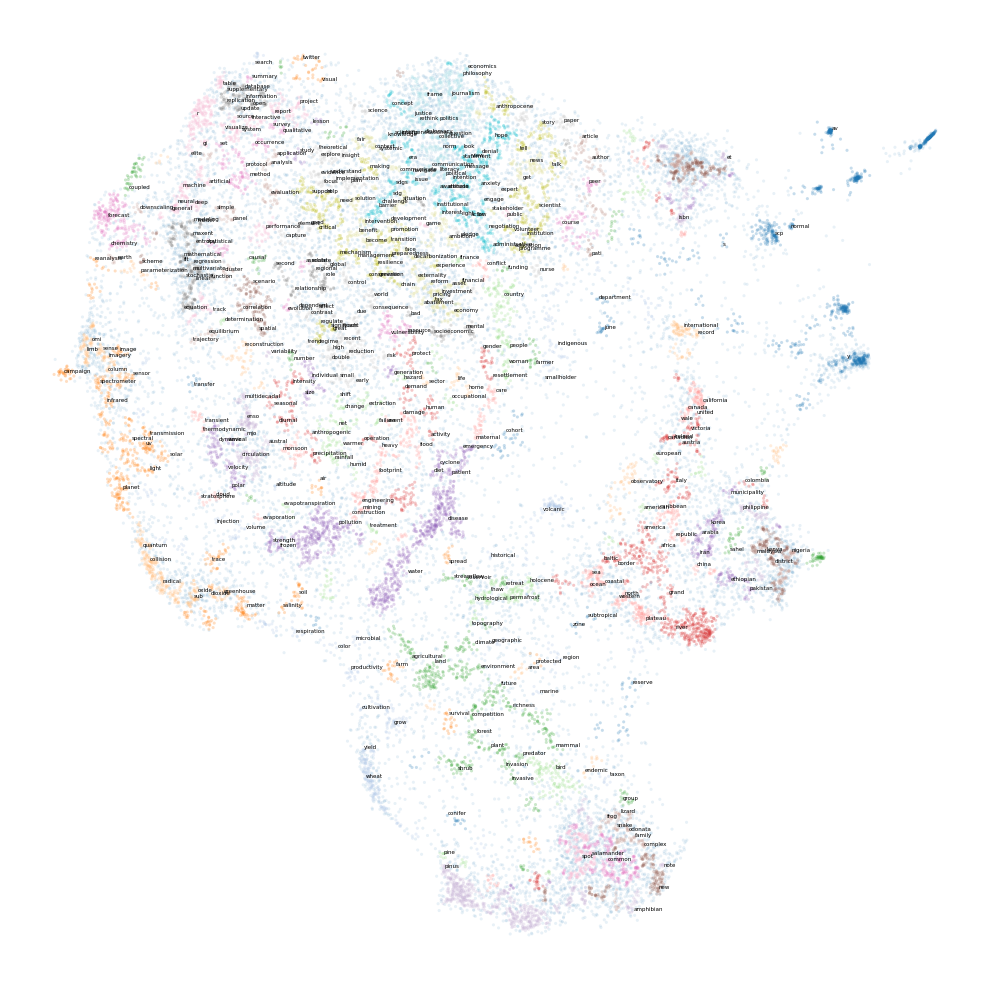

In [13]:
# Création d'une figure
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    s=5,
    edgecolor='none',
    alpha=np.where(cluster_labels==-1, 0.1, 0.25),
    c=cluster_labels,
    cmap="tab20",
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embedding[:, 0],
    "y": embedding[:, 1],
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=4)

plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_clusters.pdf")

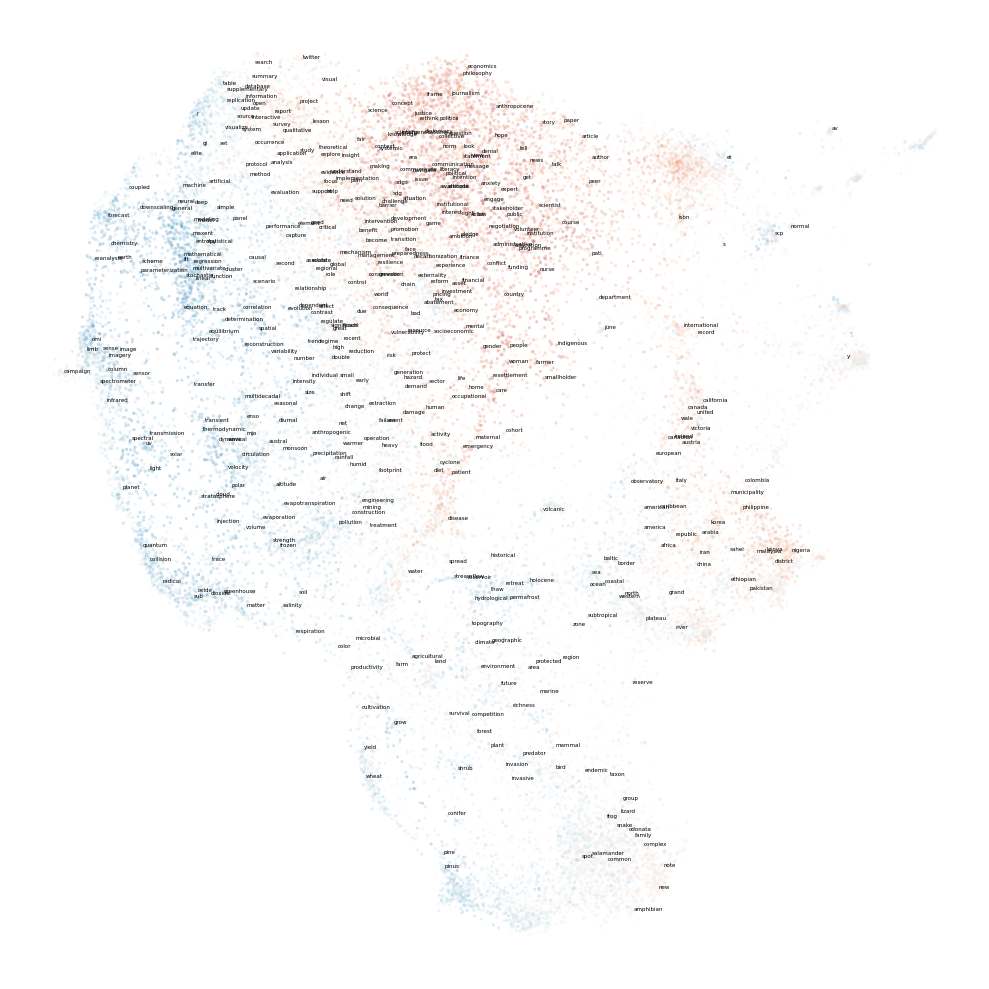

In [17]:
genders = [cosine(average_female-average_male, vector) for vector in vectors]

# Plot the result
plt.figure(figsize=(10, 10))
plt.scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    s=5,
    edgecolor='none',
    alpha=0.25,
    c=genders,
    cmap="RdBu",
    vmin=np.min(genders),
    vmax=np.max(genders)
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embedding[:, 0],
    "y": embedding[:, 1],
    "gender": genders,
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=4)


plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_gender.pdf")